# GENERATING ARTISTIC IMAGES

**BASIC INTRODUCTION**

During the completion of this task, I read and came across a beautiful idea of **Neural Style Transfer**.  It builds on the key aspect that we can separate the **style representation** and **content representation** in a Convolution Neural Network(**CNN**), during any task involving image recognition to name a few. Ever thought how your painting would have looked if it would have been painted in the style of Leonardo da Vinci or Picasso? 

**HOW EXACTLY NST WORKS?**

NST employs a pretrained or a newly trained CNN to transfer styles from a given image to another. We will be dealing with primarily three images i.e **content image, style image** and a **generated image(output image)**. Our task will be to define such loss functions that will **minimize the difference** between these images. The artworks that can be generated will be like:

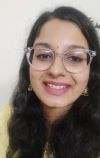 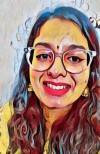

**WHAT IS THE ARCHITECTURE?**

To define a loss function which blends two images seamlessly to create visually appealing art, NST defines the following inputs:

* ***A content image (c)*** - the image we want to transfer a style to*

* ***A style image (s)*** - the image we want to transfer the style from*

* ***An input (generated) image (g)*** - the image that contains the final result (**the only trainable variable**)
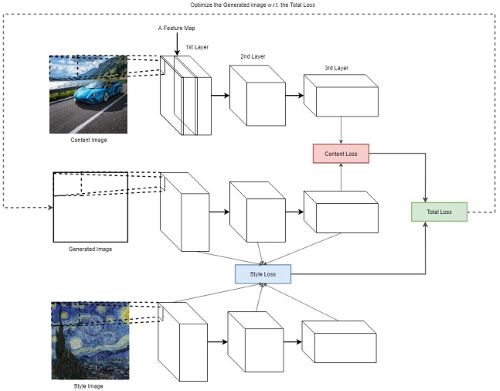
The most common choices for the base CNN architecture are **VGG (Visual Geometry Group)** and sometimes other architectures like **ResNet or Inception**. VGG is frequently used due to its simplicity and good performance in image-related tasks. The main idea is to use the pre-trained CNN as a feature extractor. The convolutional layers of the network capture hierarchical features of the input image. These features become representations of content and style. The feature maps from specific layers of the CNN are chosen to represent content and style. **Typically, lower layers capture fine details and high-frequency information (content), while higher layers capture more abstract and global patterns (style)**. Two types of loss functions are defined:

* **Content Loss**: Measures the difference between the content of the generated image and the content of the target image. It is usually the mean squared difference between the feature maps of the content image and the generated image at the chosen content layers.

* **Style Loss**: Measures the difference between the style of the generated image and the style of the target image. It is calculated as the mean squared difference of the Gram matrices of the feature maps at the chosen style layers. Gram matrix encodes the correlations between different features.

The use of pre-trained models for NST falls under the umbrella of **transfer learning**. Transfer learning leverages knowledge gained from one task (e.g., image classification) to perform effectively on another related task (e.g., style transfer).

Overall, the neural style transfer architecture combines content and style information from two input images to generate a new image that preserves the content of one and the artistic style of the other. The choice of layers for content and style representations, as well as hyperparameters, can be adjusted to achieve different artistic effects.



# MY OWN MINIVGG16

Here is my **very naive attempt** in making my own **Mini VGG 16 Network** using **pyTorch**. It consists of **16 convolutional layers** but can be extended to 19 layers as well (hence the two versions, VGG-16 and VGG-19). All the convolutional layers consists of **3x3 filters**. I have used the **CIFAR-100 dataset**. It has **100 classes with 600 images each**. There are **500 training images** and **100 testing images** per class. 
    But as the dataset is huge and my laptop is not computationally strong, it was taking a lot of time to train and hence I could not train this model. 

**INSTALLING AND IMPORTING THE DEPENDENCIES**

In [3]:
!pip install torch torchvision

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\akshi\\appdata\\local\\programs\\python\\python310\\lib\\site-packages\\torch-2.0.0.dist-info\\METADATA'



In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**LOADING THE DATA AND PREPROCESSING**

* **torchvision** is a library that provides easy access to tons of computer vision datasets and methods to pre-process these datasets in an easy and intuitive manner. 
* We then **normalise** with the **mean** and **standard deviation** of each of the channel(red, green, blue) in the dataset. 
* **Zero-mean images** are often used in various image processing and computer vision tasks. **Zero-centering** can be particularly important in deep learning applications, especially when working with convolutional neural networks (CNNs) or other models that are sensitive to the scale of input data. Zero-centering helps ensure that the learning algorithm focuses on the **patterns and structures** in the data rather than being influenced by the overall brightness or intensity of the images.
* We load the train split of the dataset and randomly split it into train and validation set **(0.9:0.1)**.
* Finally, we make use of **data loaders**.  Data loaders allow us to iterate through the data in **batches**, and the data is loaded while iterating and not all at once in start into your RAM.


In [5]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR100(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR100(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR100 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**VGG16 FROM SCRATCH**

The various types of layers are as follows:
* **nn.Conv2d**: accepts the number of input and output channels as arguments, along with kernel size for the filter. It also accepts any strides or padding
* **nn.BatchNorm2d**: applies batch normalization to the output from the convolutional layer
* **nn.ReLU**: the activation applied to various outputs in the network
* **nn.MaxPool2d**: applies max pooling to the output with the kernel size given
* **nn.Dropout**: is used to apply dropout to the output with a given probability
* **nn.Linear**: is a fully connected layer
* **nn.Sequential**: is technically not a type of layer but it helps in combining different operations that are part of the same step

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

**SETTING THE HYPERPARAMETERS**

In [9]:
num_classes = 100
num_epochs = 10
batch_size = 16
learning_rate = 0.05

model = VGG16(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)

**TRAINING THE MODEL**

* For every epoch, we go through the images and labels inside our train_loader.
* We use our model to predict on the labels and then calculate the loss between the predictions and the true labels using our loss function.
* Then we use that loss to backpropagate and update the weights. Also we set the gradients to zero before every update.
* At the end of every epoch we use our validation set to calculate the accuracy of the model

In [ ]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

# USING A PRE-TRAINED VGG19 MODEL

**INSTALLING AND IMPORTING THE DEPENDENCIES**

In [8]:
from io import BytesIO

In [9]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [10]:
!pip install requests

**SETTING THE HYPERPARAMETERS** 

In [11]:
ITERATIONS = 10 
IMAGE_WIDTH = 512 # 512x512 is fine for HD images
IMAGE_HEIGHT = 512
CONTENT_WEIGHT = 1 # Weight of the content loss
STYLE_WEIGHT = 10 # Weight of the style loss
TOTAL_VARIATION_WEIGHT = 10 # Weight of the total variation loss
INPUT_IMAGE = 'noise' # Can be : 'noise', 'content', 'style', or a path to a file

**LOSS FUNCTIONS**

* To compute the style of an image, we run the image through VGG19. Then, we look at what values flowed across the layers.
* For the **content**, we usually keep the first layers. The **last convolutional layer** from the second block is always a good bet.
* For the **style**, a mix of the **first convolutional layers** (contain **color and texture** information) and **last layers** (contain **complex features** like trees, shapes, eyes, etc) gives the best results.

In [12]:
content_layers = ['relu_9']
style_layers = ['relu_1', 'relu_3', 'relu_5', 'relu_9', 'relu_13']

**NAMES UNDER WHICH FILES ARE SAVED**

In [13]:
content_image_path = "content.png"
style_image_path = "style.png"
output_image_path = "result.png"
combined_image_path = "combined.png"

**IMAGE SELECTION**

In [22]:
# Content images
city = "https://images.pexels.com/photos/1722183/pexels-photo-1722183.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
cup = "https://images.pexels.com/photos/2180094/pexels-photo-2180094.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
  
# Style images:
tytus = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"
tytus_second = "http://t-b.pl/attachments/kamienice-na-pancerze-2017.jpg"
vincent = "https://www.researchgate.net/profile/Sebastian-Penhouet-2/publication/330383053/figure/fig2/AS:715176177307648@1547522696184/Neural-Style-Transfer-example-of-Tuebingens-Nackarfront-in-the-style-of-Vincent-van-Goghs.jpg"

# The function wich allow us to download / open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)


In [23]:
content_url = city
style_url = tytus

**IMAGE LOADING**

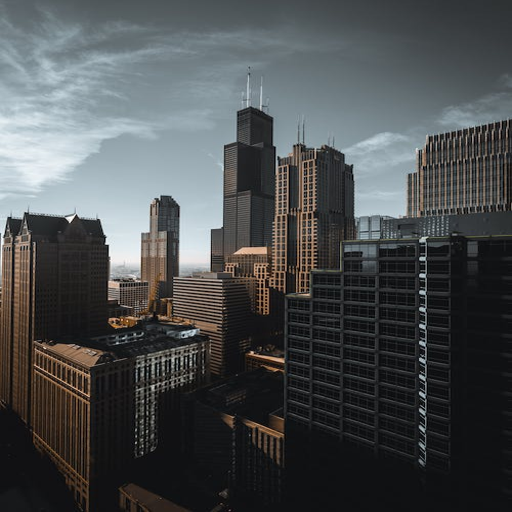

In [24]:
#@title This is the _content_ image
import requests
content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image.save(content_image_path)
content_image

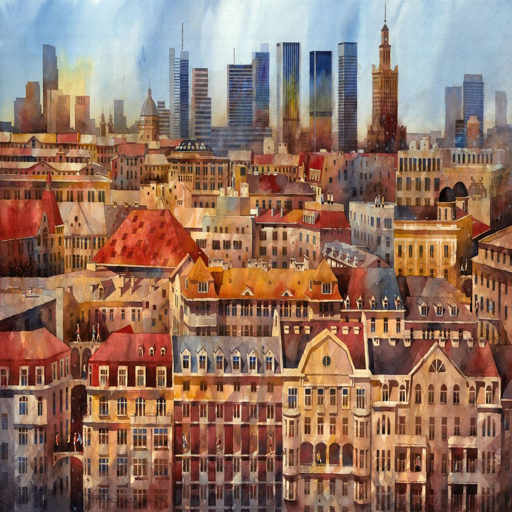

In [25]:
style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

**FEATURE LOSSES**

* The first loss is the **content loss**, based on what content an image contains. It is basically like a Mean Square Error. But instead of computing the MSE on the content image's pixels and the computed image's pixels, we compute the MSE between the activation of **some layers** of VGG19 after running our images through it.
* The second loss is the **style loss**. We compute the **gram matrix**, which is a matrix whose coefficients are the **dot product of two features vectors** in the same activation layer from a single image. We then have for each activation layer, two gram matrix (one from the style image, and one from the content image). We compute the **MSE between the pairs of matrices**.

In [26]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # We 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable.
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input
     

In [27]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    # Here:
    # a is the batch size(=1)
    # b is the number of feature maps
    # (c,d) are the dimensions of a feature map

    # We reshape the activation layer into a collection of feature vectors
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())  

    # We 'normalize' the values of the gram matrix
    # by dividing by the norm of gram matrix filled with ones.
    return G.div((a * b * c * d) ** 0.5)

**TOTAL LOSS**

* This is called the **total variation** because it basically counts the amplitude of all the variations happening in the image. **Hight amplitude** variation are caused by **high constrats / brutal change** of pixel values.
* Minimizing the total variation of an image can be considered as **reducing noise** (it is called **total variation denoising**). But an image with a minimal total variation is a **uniformly colored square**. And it would be a really boring and uninteresting picture. **Too much total variation weight** will lead to **darker / less colorful images**. But **too few** of it will generate **very noisy** images, without the "brush painting" style we are often looking for in style transfer.

In [28]:
def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])
     

**NORMALISATION**

While training neural network on image dataset, all imges are their mean removed, and values are rescaled according to the standard deviation of the dataset. This is a common processing which makes the neural network convergence easier. (As explained earlier also under 'My OWN MINI VGG16')

In [29]:
# Create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Reshape the mean and std to make them [C x 1 x 1] so that they can
    # directly broadcast to image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std


**DOWNLOADING THE MODEL VGG19**

We only keep the layers required to compute the feature loss, and throw everything else away. We interleave our **Normalization, StyleLoss and ContentLoss layers** between VGG19's layers.

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

C:\Users\akshi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\akshi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # We make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)
  
  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # We rebuild the model as a nn sequential whose first layer is
  # our normalization layer.
  model = nn.Sequential(normalization)

  # We brows the layer of `cnn` and stack them into `model`.
  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # to keep the model as small as possible.
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

**RUNNING THE ALGORITHM**

A function to convert PIL images to a torch.Tensor and applying it to our images

In [33]:
def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

Declaring the inverse function, converting back tensors to images

In [34]:
# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

Generating or loading the input image from which we are going to converge.

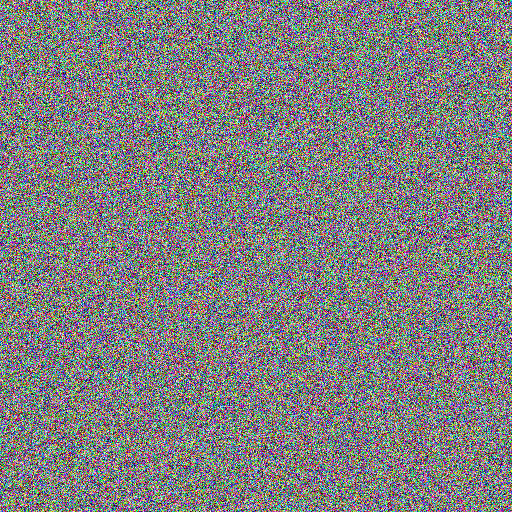

In [35]:
#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

# To visualise it better, instead of clipping values, we rescale
# them to fit [-1,1], and convert to an image. This is mostly because
# the visualization given is closer to what the actual values stored
# in the tensor are.
if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])
img

The algorithm giving the best visual result is **LBFGS for our gradient descent**.

In [36]:
def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

In [37]:
def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.plot(history[2], label='Variation')
    plt.plot(history[3], label='Sum')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f} Sum: {:4f}'.format(
        history[0][-1], history[1][-1], history[2][-1], history[3][-1]))
     

**CONVERGING TO THE ARTISTIC IMAGE AND EVALUATION**

As my laptop is not computationally upto the mark, I could not train it for more than 20 iterations. For the best results, it would require atleast 1000 iterations. But you can see that as the model gets trained, all the losses are decreasing.

Building the style transfer model..


C:\Users\akshi\AppData\Local\Temp\ipykernel_15260\3933682407.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\akshi\AppData\Local\Temp\ipykernel_15260\3933682407.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..


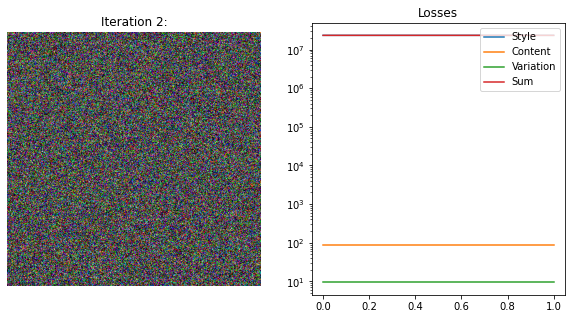

Style Loss : 23277552.000000 Content Loss: 86.945633 Variation Loss: 9.400341 Sum: 23277648.000000


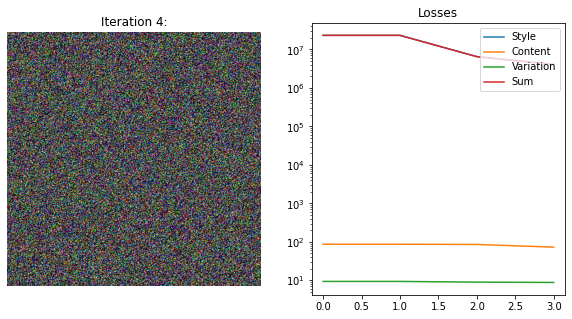

Style Loss : 4075408.000000 Content Loss: 73.096909 Variation Loss: 8.843022 Sum: 4075489.750000


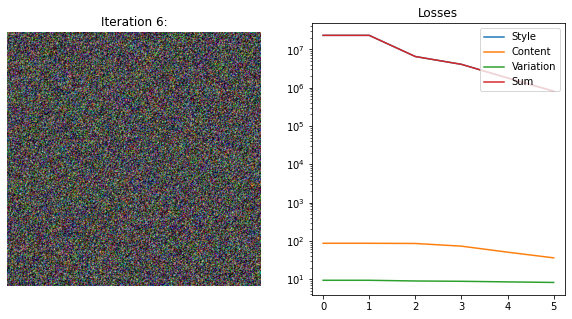

Style Loss : 812118.812500 Content Loss: 36.197041 Variation Loss: 8.253859 Sum: 812163.250000


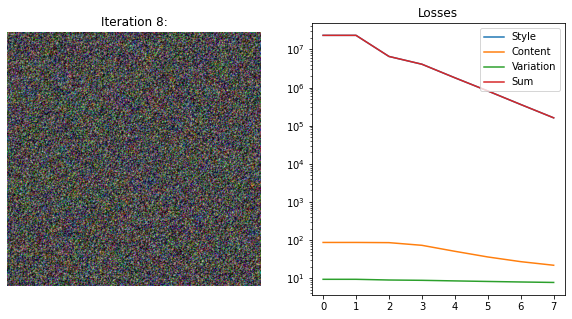

Style Loss : 160347.234375 Content Loss: 21.943769 Variation Loss: 7.776505 Sum: 160376.953125


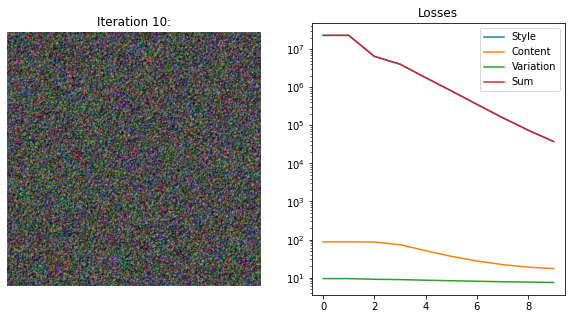

Style Loss : 37635.089844 Content Loss: 17.165224 Variation Loss: 7.441581 Sum: 37659.695312


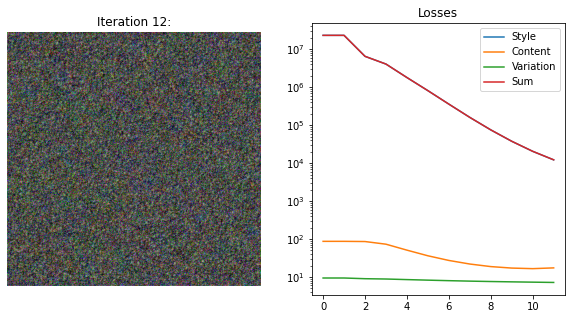

Style Loss : 12198.464844 Content Loss: 17.364294 Variation Loss: 7.179434 Sum: 12223.008789


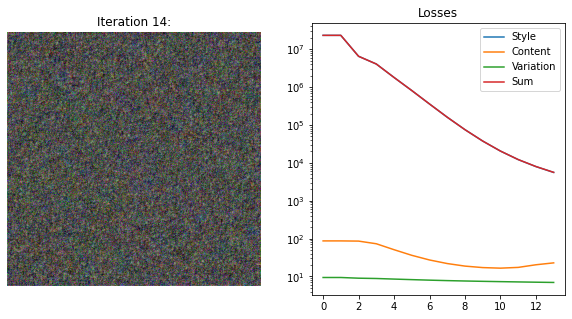

Style Loss : 5588.487305 Content Loss: 22.867205 Variation Loss: 6.955255 Sum: 5618.309570


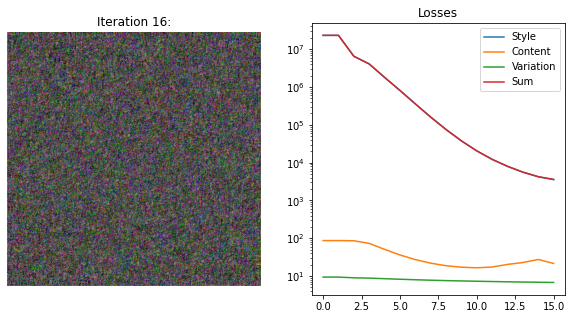

Style Loss : 3567.935791 Content Loss: 21.556364 Variation Loss: 6.789346 Sum: 3596.281494


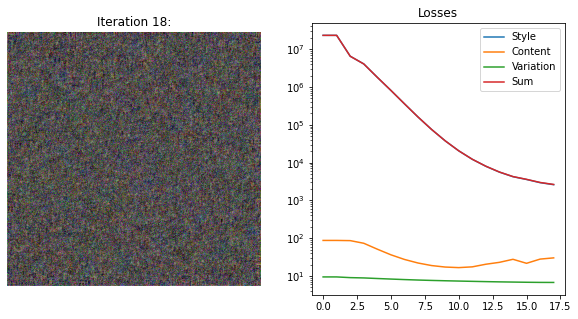

Style Loss : 2597.205811 Content Loss: 30.015871 Variation Loss: 6.715086 Sum: 2633.936768


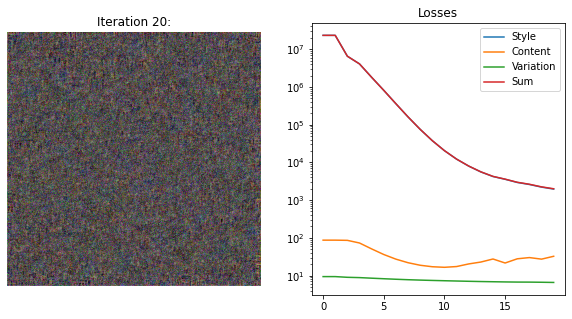

Style Loss : 1961.989746 Content Loss: 32.483120 Variation Loss: 6.581182 Sum: 2001.054077


In [38]:
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)
optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0
history=[]
while iterations <= ITERATIONS:
  # Compute the loss and backpropagate to the input_image.
  # (The LBFGS optimizer only accept work through closures.)
  def closure():
      global history
      global iterations
      
      optimizer.zero_grad()
      
      # Compute the total variation loss
      variation_score = total_variation_loss(input_img) * TOTAL_VARIATION_WEIGHT
      # Compute the features through the model
      model(input_img)
      # Compute style and content losses
      style_score = sum(sl.loss for sl in style_losses)
      style_score *= STYLE_WEIGHT / len(style_losses)
      content_score = sum(cl.loss for cl in content_losses)
      content_score *= CONTENT_WEIGHT / len(content_losses)
      # Our global loss is the sum of the 3 values
      loss = style_score + content_score + variation_score
      # Save the value of loss in order to draw them as a graph
      history += [[style_score.item(), content_score.item(), variation_score.item(), loss.item()]]

      # If the iteration is a multiple of 2, display some informations
      iterations += 1
      if iterations % 2 == 0:
          show_evolution(input_img.data.clone().detach().clamp(0, 1), history, title="Iteration %d:" % iterations)
      
      # Backpropagate gradients and leave the optimizer do his job.
      loss.backward()
      return loss

  optimizer.step(closure)

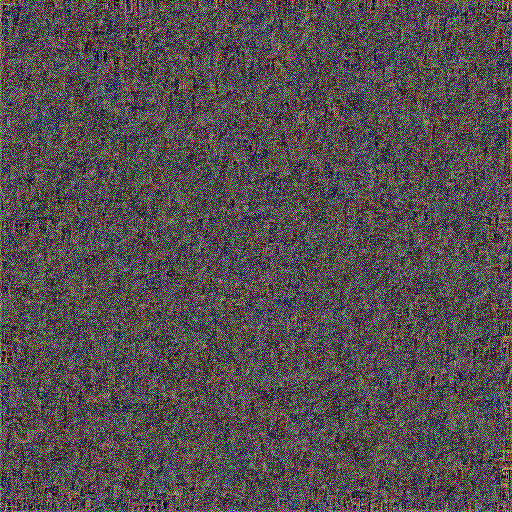

In [39]:
#@title Our result
img = tensor_to_image(input_img)
img.save(output_image_path)
img
     

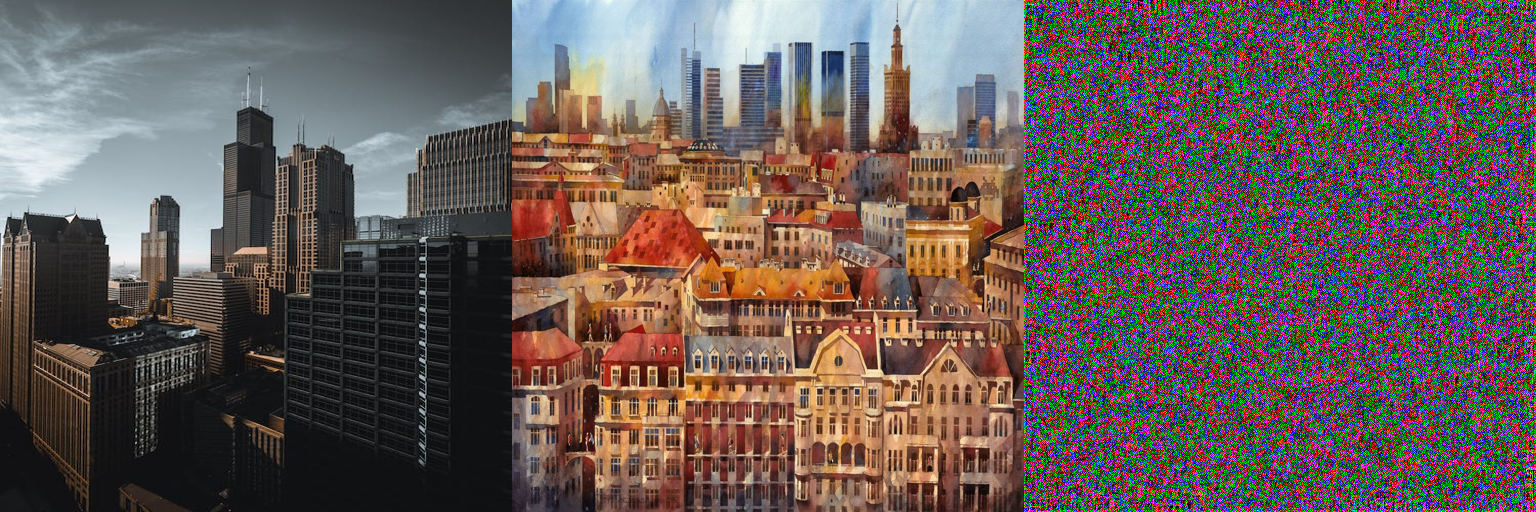

In [40]:
#@title Visualise combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [content_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined

# LIMITATIONS IN THE MODEL

* Firstly, this model has not been trained for the minimum required number of iterations that maybe 1000 or above. That is why the output is still very noisy and grainy. Provided that the system's computational power is enough, this model I am sure can provide really good results. So, for systems not having good processors is a limitation.

*  Style transfer models typically require a large dataset of diverse styles for training. The quality of the generated images heavily depends on the variety and quality of the styles present in the training data. If the model hasn't seen a particular style during training, it may not handle it well during style transfer.

*  Neural style transfer models can sometimes overfit to the specific styles present in the training data. This means that the model might struggle with styles significantly different from those in the training set.

*  Applying neural style transfer to videos is more challenging than to still images. Temporal coherence and consistency are critical for video style transfer, and achieving this without introducing flickering or other artifacts can be difficult.

# IMPROVEMENTS IN THE MODEL

* Experimenting with more advanced neural network architectures, such as attention mechanisms or generative adversarial networks (GANs), can lead to better performance in capturing complex style patterns.
* Developing models that can handle multiple styles in a single image or video transfer can enhance the flexibility and creative possibilities of the technique.
* Incorporating semantic information into style transfer models can improve the coherence of generated images. This involves designing models that understand the content of the images at a higher level. 
* We can check for some other models apart from VGG Network or can construct another VGG Network with increased number of convolutional layers.
* We can also try out different optimisers, and try training the model for different set of hyperparameters for the maximum efficiency and accuracy.